In [9]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [10]:
# Генерация искусственных данных
np.random.seed(42)
N = 10000

# Диапазоны для переменных x1–x5
x1_vals = np.random.uniform(0.0, 5.5, N)
x2_vals = np.random.uniform(0.0, 5.0, N)
x3_vals = np.random.uniform(0.0, 5.5, N)
x4_vals = np.random.uniform(0.0, 1.4, N)
x5_vals = np.random.uniform(0.0, 8.7, N) 

X = np.vstack([x1_vals, x2_vals, x3_vals, x4_vals, x5_vals]).T

In [11]:
# Эвристика для генерации целевых значений
Kp = 10 + 2 * x1_vals + 0.5 * x5_vals + np.random.normal(0, 0.2, N)
Ki = 5 + 1 * x1_vals + 0.3 * x5_vals + np.random.normal(0, 0.2, N)

Kp = np.clip(Kp, 15.47, 20.0)
Ki = np.clip(Ki, 12.26, 15.0)

Y = np.vstack([Kp, Ki]).T

In [12]:
# Масштабирование
scaler_X = StandardScaler()
scaler_Y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_Y, "scaler_Y.pkl")

['scaler_Y.pkl']

In [13]:
# Подготовка данных для обучения
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
Y_tensor = torch.tensor(Y_scaled, dtype=torch.float32)
dataset = TensorDataset(X_tensor, Y_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [14]:
# Модель PINet
class PINet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )
    def forward(self, x):
        return self.net(x)

model = PINet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [15]:
# Обучение
epochs = 300
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in loader:
        optimizer.zero_grad()
        pred = model(batch_x)
        loss = loss_fn(pred, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if epoch % 25 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch:3d}/{epochs} | Loss: {total_loss:.5f}")

Epoch   0/300 | Loss: 5.31839
Epoch  25/300 | Loss: 0.18783
Epoch  50/300 | Loss: 0.15873
Epoch  75/300 | Loss: 0.15434
Epoch 100/300 | Loss: 0.14763
Epoch 125/300 | Loss: 0.14546
Epoch 150/300 | Loss: 0.14804
Epoch 175/300 | Loss: 0.14314
Epoch 200/300 | Loss: 0.14295
Epoch 225/300 | Loss: 0.14171
Epoch 250/300 | Loss: 0.13740
Epoch 275/300 | Loss: 0.13802
Epoch 299/300 | Loss: 0.13456


In [16]:
# Сохранение модели
torch.save(model.state_dict(), "ML-neuro-pi2.pt")
print("Модель сохранена в файл: ML-neuro-pi2.pt")

# Предсказания
model.eval()
with torch.no_grad():
    y_pred_scaled = model(torch.tensor(X_scaled, dtype=torch.float32)).numpy()

y_pred = scaler_Y.inverse_transform(y_pred_scaled)
y_true = scaler_Y.inverse_transform(Y_scaled)

Модель сохранена в файл: ML-neuro-pi2.pt


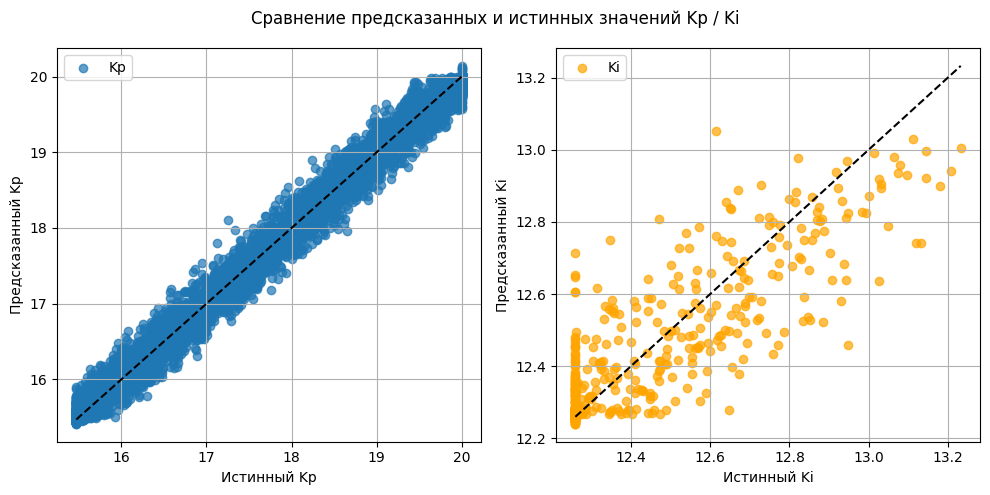

Диапазон Kp: 15.47 20.0
Диапазон Ki: 12.26 13.232305778009941
MAE по Kp: 0.08, MAE по Ki: 0.01
RMSE в масштабе scaler'а: 0.0286


In [17]:
# Визуализация
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_true[:, 0], y_pred[:, 0], alpha=0.7, label='Kp')
plt.plot([y_true[:, 0].min(), y_true[:, 0].max()],
         [y_true[:, 0].min(), y_true[:, 0].max()], 'k--')
plt.xlabel('Истинный Kp')
plt.ylabel('Предсказанный Kp')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_true[:, 1], y_pred[:, 1], alpha=0.7, color='orange', label='Ki')
plt.plot([y_true[:, 1].min(), y_true[:, 1].max()],
         [y_true[:, 1].min(), y_true[:, 1].max()], 'k--')
plt.xlabel('Истинный Ki')
plt.ylabel('Предсказанный Ki')
plt.grid(True)
plt.legend()

plt.suptitle('Сравнение предсказанных и истинных значений Kp / Ki')
plt.tight_layout()
plt.show()

# Метрики
print("Диапазон Kp:", Kp.min(), Kp.max())
print("Диапазон Ki:", Ki.min(), Ki.max())

mae_kp = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
mae_ki = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
rmse_scaled = np.sqrt(mean_squared_error(Y_scaled, y_pred_scaled))

print(f"MAE по Kp: {mae_kp:.2f}, MAE по Ki: {mae_ki:.2f}")
print(f"RMSE в масштабе scaler'а: {rmse_scaled:.4f}")